In [1]:
#We load in the specific data needed
import polars as pl
import numpy as np
import os
from pathlib import Path
import pandas as pd
from datetime import date
import datetime
import hvplot.polars
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.interpolate import bisplrep, bisplev
from datetime import timedelta
from patsy import dmatrix
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, r2_score

data = pd.read_parquet('/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Data/updated_standardization/data_set_train_tech_nonscaled.parquet')
datat = pd.read_parquet('/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Data/updated_standardization/data_set_test_tech_nonscaled.parquet')
firm_data = pd.read_parquet('/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Data/Firm_variables/daily_firm_data_median_new.parquet')

columns_todrop = list(firm_data.columns[2:]) + ['moneyness_squared', 'tau_squared', 'moneyness_tau', 'RETX', '2Y_bond', 'best_offer_option', 'best_bid_option']

columnstodrop_ex = ['const',
 'moneyness',
 'prev2_day_iv',
 'prev_day_iv',
 'trading_days_till_exp',
 '5_day_rolling_return_stock',
 'PRC',
 'PRC_actual',
 'RET',
 'RETX',
 'cumulative_return',
 'daily_return_indicator_stock',
 'vol_stock',
 '10Y_RIR',
 '1Y_bond',
 '2Y_bond',
 'CLOSE_vix',
 'FF_rate',
 'OPEN_vix',
 'gold_price',
 'reces_indi']

datat.drop(columns=columns_todrop, inplace=True, errors='ignore')
data.drop(columns=columns_todrop, inplace=True, errors='ignore')

datat.drop(columns=[ 'T'], inplace=True)
data.drop(columns=[ 'T'], inplace=True)

test_data = datat[datat['date'] >= '2021-01-01']
total_train = data[data['date'] < '2021-01-01']

In [28]:
selected_columns = ['Ticker', 'date', 'cp_flag', 'impl_volatility', 'moneyness', 'T', 'moneyness_squared', 'tau_squared', 'moneyness_tau']

data = pd.read_parquet('/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Data/updated_standardization/data_set_train_tech_nonscaled.parquet')
datat = pd.read_parquet('/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Data/updated_standardization/data_set_test_tech_nonscaled.parquet')

test_data = datat[datat['date'] >= '2021-01-01']
total_train = data[data['date'] < '2021-01-01']

puts_data_all = total_train[total_train['cp_flag'] == 'P']
puts_data_test = test_data[test_data['cp_flag'] == 'P']
calls_data_all = total_train[total_train['cp_flag'] == 'C']
calls_data_test = test_data[test_data['cp_flag'] == 'C']

train_calls_data = calls_data_all[selected_columns]
test_calls_data = calls_data_test[selected_columns]
train_puts_data = puts_data_all[selected_columns]
test_puts_data = puts_data_test[selected_columns]

test_puts_data

,Ticker,date,cp_flag,impl_volatility,moneyness,T,moneyness_squared,tau_squared,moneyness_tau
36352,AAPL,2021-01-04,P,0.622737,-1.977,0.019841,3.908529,0.000394,-0.039226
36353,AAPL,2021-01-04,P,0.598160,-1.835,0.019841,3.367225,0.000394,-0.036409
36354,AAPL,2021-01-04,P,0.570362,-1.694,0.019841,2.869636,0.000394,-0.033611
36355,AAPL,2021-01-04,P,0.549241,-1.554,0.019841,2.414916,0.000394,-0.030833
36356,AAPL,2021-01-04,P,0.526871,-1.415,0.019841,2.002225,0.000394,-0.028075
...,...,...,...,...,...,...,...,...,...
71690,TSLA,2021-12-30,P,0.484270,-0.027,0.007937,0.000729,0.000063,-0.000214
71691,TSLA,2021-12-30,P,0.503165,0.081,0.007937,0.006561,0.000063,0.000643
71692,TSLA,2021-12-30,P,0.536047,0.190,0.007937,0.036100,0.000063,0.001508
71693,TSLA,2021-12-30,P,0.550971,0.298,0.007937,0.088804,0.000063,0.002365


# Create a filtered version

In [29]:
train_puts_data_aapl = train_puts_data[train_puts_data['Ticker']=='NVDA']
test_puts_data_aapl = test_puts_data[test_puts_data['Ticker']=='NVDA']

AHBS Model Summary for Puts (cp_flag = 'P'):
                            OLS Regression Results                            
Dep. Variable:        impl_volatility   R-squared:                       0.112
Model:                            OLS   Adj. R-squared:                  0.112
Method:                 Least Squares   F-statistic:                     231.9
Date:                Fri, 11 Oct 2024   Prob (F-statistic):          7.12e-234
Time:                        12:15:27   Log-Likelihood:                -2033.6
No. Observations:                9198   AIC:                             4079.
Df Residuals:                    9192   BIC:                             4122.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------

/var/folders/b4/wn87d6495j1_vytb8m33q3mm0000gn/T/ipykernel_20700/3049932616.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_puts_data_aapl['predicted_impl_volatility'] = adhbs_model_puts.predict(sm.add_constant(train_puts_data_aapl[['moneyness', 'moneyness_squared', 'T', 'tau_squared', 'moneyness_tau']]))


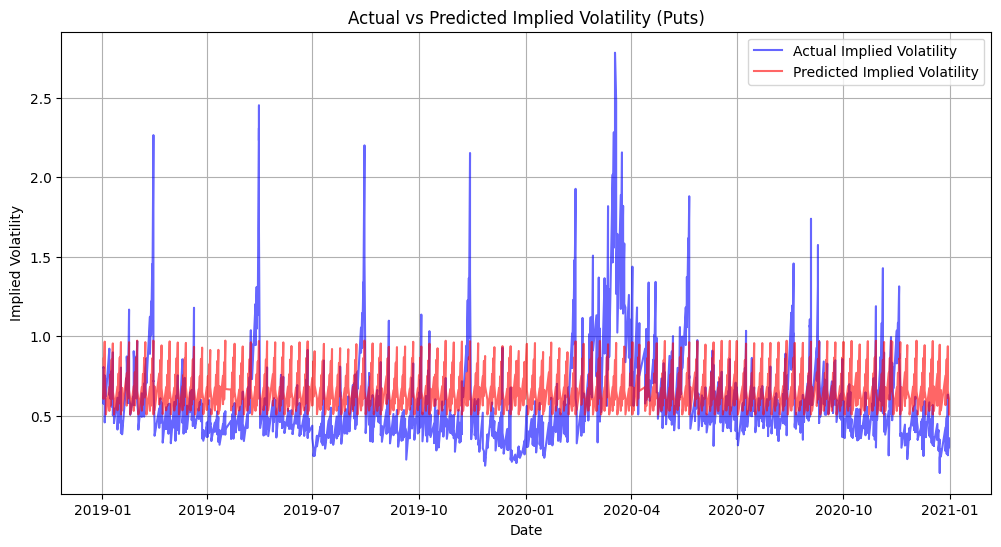

In [30]:
# Function to fit AHBS model
def adhbs_model(data):
    X = data[['moneyness', 'moneyness_squared', 'T', 'tau_squared', 'moneyness_tau']]
    X = sm.add_constant(X)
    y = data['impl_volatility']
    model = sm.OLS(y, X).fit()
    return model

# Fit the AHBS model for puts
adhbs_model_puts = adhbs_model(train_puts_data_aapl)
print("AHBS Model Summary for Puts (cp_flag = 'P'):")
print(adhbs_model_puts.summary())

# Generate predictions using the model
train_puts_data_aapl['predicted_impl_volatility'] = adhbs_model_puts.predict(sm.add_constant(train_puts_data_aapl[['moneyness', 'moneyness_squared', 'T', 'tau_squared', 'moneyness_tau']]))

# Plot actual vs predicted implied volatility
plt.figure(figsize=(12, 6))
plt.plot(train_puts_data_aapl['date'], train_puts_data_aapl['impl_volatility'], label='Actual Implied Volatility', color='blue', alpha=0.6)
plt.plot(train_puts_data_aapl['date'], train_puts_data_aapl['predicted_impl_volatility'], label='Predicted Implied Volatility', color='red', alpha=0.6)
plt.xlabel('Date')
plt.ylabel('Implied Volatility')
plt.title('Actual vs Predicted Implied Volatility (Puts)')
plt.legend()
plt.grid(True)
plt.show()


In [27]:
test_puts_data_aapl

,Ticker,date,cp_flag,impl_volatility,moneyness,T,moneyness_squared,tau_squared,moneyness_tau,predicted_impl_volatility


AHBS Model Summary for Puts (In-Sample, cp_flag = 'P'):
                            OLS Regression Results                            
Dep. Variable:        impl_volatility   R-squared:                       0.112
Model:                            OLS   Adj. R-squared:                  0.112
Method:                 Least Squares   F-statistic:                     231.9
Date:                Fri, 11 Oct 2024   Prob (F-statistic):          7.12e-234
Time:                        12:17:54   Log-Likelihood:                -2033.6
No. Observations:                9198   AIC:                             4079.
Df Residuals:                    9192   BIC:                             4122.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------

/var/folders/b4/wn87d6495j1_vytb8m33q3mm0000gn/T/ipykernel_20700/502878825.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_puts_data_aapl['predicted_impl_volatility'] = adhbs_model_puts.predict(sm.add_constant(train_puts_data_aapl[['moneyness', 'moneyness_squared', 'T', 'tau_squared', 'moneyness_tau']]))
/var/folders/b4/wn87d6495j1_vytb8m33q3mm0000gn/T/ipykernel_20700/502878825.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_puts_data_aapl['predicted_impl_volatility'] = adhbs_model_puts

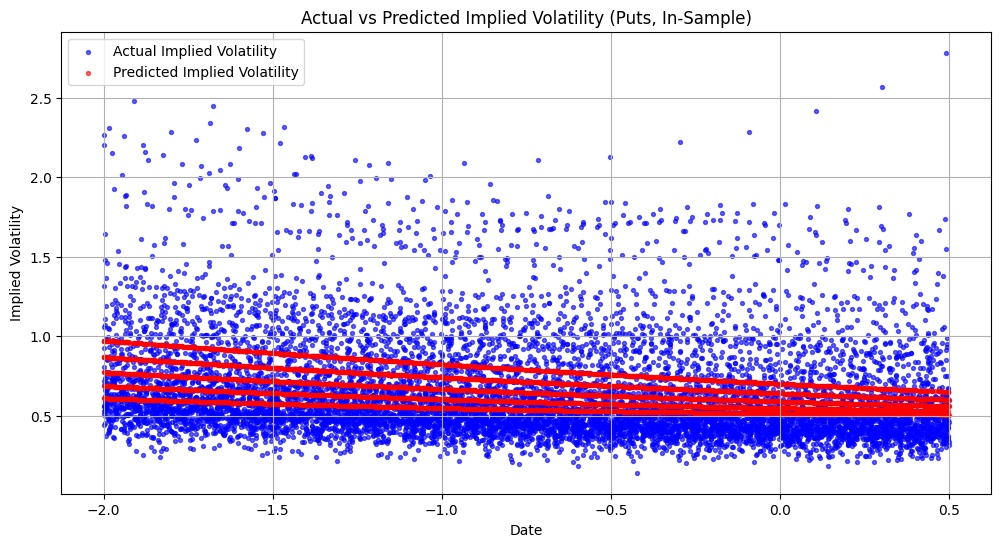

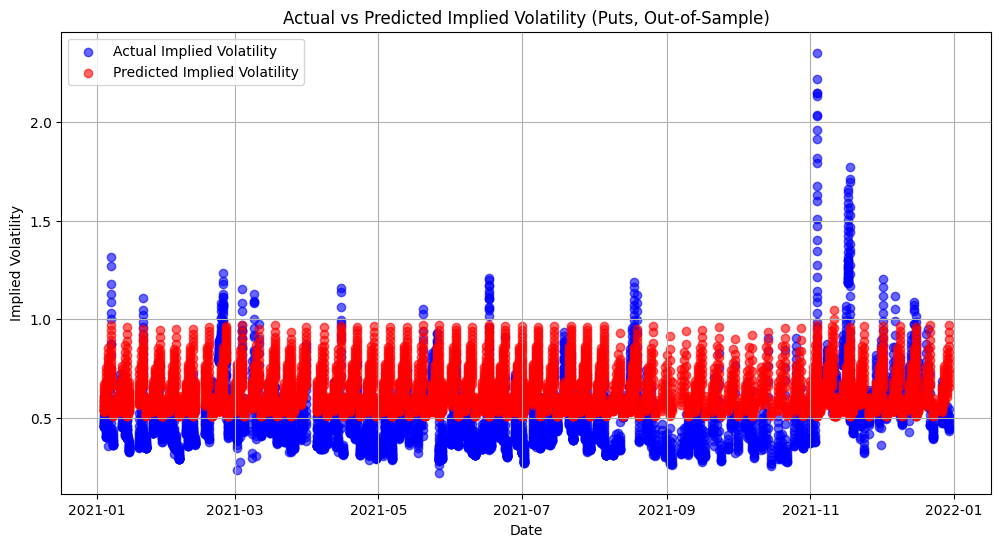

In [32]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# Function to fit AHBS model
def adhbs_model(data):
    X = data[['moneyness', 'moneyness_squared', 'T', 'tau_squared', 'moneyness_tau']]
    X = sm.add_constant(X)
    y = data['impl_volatility']
    model = sm.OLS(y, X).fit()
    return model

# Fit the AHBS model for puts (In-Sample)
adhbs_model_puts = adhbs_model(train_puts_data_aapl)
print("AHBS Model Summary for Puts (In-Sample, cp_flag = 'P'):")
print(adhbs_model_puts.summary())

# Generate in-sample predictions for puts
train_puts_data_aapl['predicted_impl_volatility'] = adhbs_model_puts.predict(sm.add_constant(train_puts_data_aapl[['moneyness', 'moneyness_squared', 'T', 'tau_squared', 'moneyness_tau']]))

# Out-of-sample prediction for puts
test_puts_data_aapl['predicted_impl_volatility'] = adhbs_model_puts.predict(sm.add_constant(test_puts_data_aapl[['moneyness', 'moneyness_squared', 'T', 'tau_squared', 'moneyness_tau']]))

# Calculate Out-of-Sample R^2 and RMSE for puts
r2_puts = r2_score(test_puts_data_aapl['impl_volatility'], test_puts_data_aapl['predicted_impl_volatility'])
rmse_puts = np.sqrt(mean_squared_error(test_puts_data_aapl['impl_volatility'], test_puts_data_aapl['predicted_impl_volatility']))

print(f"Out-of-Sample R^2 for Puts: {r2_puts}")
print(f"Out-of-Sample RMSE for Puts: {rmse_puts}")

# Plot actual vs predicted implied volatility for puts (In-Sample)
plt.figure(figsize=(12, 6))
plt.scatter(train_puts_data_aapl['moneyness'], train_puts_data_aapl['impl_volatility'], label='Actual Implied Volatility', color='blue', alpha=0.6, s=8)
plt.scatter(train_puts_data_aapl['moneyness'], train_puts_data_aapl['predicted_impl_volatility'], label='Predicted Implied Volatility', color='red', alpha=0.6, s=8)
plt.xlabel('Date')
plt.ylabel('Implied Volatility')
plt.title('Actual vs Predicted Implied Volatility (Puts, In-Sample)')
plt.legend()
plt.grid(True)
plt.show()

# Plot actual vs predicted implied volatility for puts (Out-of-Sample)
plt.figure(figsize=(12, 6))
plt.scatter(test_puts_data_aapl['date'], test_puts_data_aapl['impl_volatility'], label='Actual Implied Volatility', color='blue', alpha=0.6)
plt.scatter(test_puts_data_aapl['date'], test_puts_data_aapl['predicted_impl_volatility'], label='Predicted Implied Volatility', color='red', alpha=0.6)
plt.xlabel('Date')
plt.ylabel('Implied Volatility')
plt.title('Actual vs Predicted Implied Volatility (Puts, Out-of-Sample)')
plt.legend()
plt.grid(True)
plt.show()
